# Histopathologic Cancer Detection - Modeling

**CU Boulder CSCA-5642**

## 1. Setup

In [1]:
import os, json, gc
from datetime import datetime
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix, 
    classification_report, precision_recall_curve
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

DATA_DIR = 'data/'
RESULTS_DIR = 'results/'
MODELS_DIR = os.path.join(RESULTS_DIR, 'saved_models')
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

np.random.seed(42)
tf.random.set_seed(42)

print(f'TensorFlow: {tf.__version__}')
print(f'GPU: {len(tf.config.list_physical_devices("GPU"))} available')

TensorFlow: 2.20.0
GPU: 0 available


## 2. Data Loading

In [2]:
def load_h5_data(filename, key):
    with h5py.File(os.path.join(DATA_DIR, filename), 'r') as f:
        return f[key][:]

train_x = load_h5_data('camelyonpatch_level_2_split_train_x.h5', 'x')
train_y = load_h5_data('camelyonpatch_level_2_split_train_y.h5', 'y').flatten()
valid_x = load_h5_data('camelyonpatch_level_2_split_valid_x.h5', 'x')
valid_y = load_h5_data('camelyonpatch_level_2_split_valid_y.h5', 'y').flatten()

print(f'Train: {train_x.shape}, Valid: {valid_x.shape}')
print(f'Class balance: {train_y.mean():.1%} tumor')

Train: (262144, 96, 96, 3), Valid: (32768, 96, 96, 3)
Class balance: 50.0% tumor


## 3. Data Preprocessing

### 3.1 Quick Mode (Optional)

In [3]:
QUICK_MODE = True
QUICK_SIZE = 20000

if QUICK_MODE:
    tumor_idx = np.where(train_y == 1)[0]
    normal_idx = np.where(train_y == 0)[0]
    samples_per_class = QUICK_SIZE // 2
    
    np.random.seed(42)
    selected = np.concatenate([
        np.random.choice(tumor_idx, samples_per_class, replace=False),
        np.random.choice(normal_idx, samples_per_class, replace=False)
    ])
    np.random.shuffle(selected)
    
    train_x = train_x[selected]
    train_y = train_y[selected]
    print(f'Quick mode: Using {len(train_x):,} samples ({train_y.mean():.1%} tumor)')
else:
    print(f'Full mode: Using {len(train_x):,} samples')

Quick mode: Using 20,000 samples (50.0% tumor)


### 3.2 Normalization & Augmentation

In [4]:
def normalize_01(x):
    return x / 255.0

train_datagen = ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=normalize_01
)

valid_datagen = ImageDataGenerator(preprocessing_function=normalize_01)

BATCH_SIZE = 64
train_generator = train_datagen.flow(train_x, train_y, batch_size=BATCH_SIZE, shuffle=True)
valid_generator = valid_datagen.flow(valid_x, valid_y, batch_size=BATCH_SIZE, shuffle=False)

print(f'Training steps/epoch: {len(train_generator)}')

Training steps/epoch: 313


## 4. Model Architectures

In [5]:
def create_simple_cnn():
    model = models.Sequential([
        layers.Input(shape=(96, 96, 3)),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_resnet50():
    base_model = ResNet50(
        include_top=False,
        weights=None,
        input_shape=(96, 96, 3),
        pooling='avg'
    )
    model = models.Sequential([
        base_model,
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_efficientnet(dropout_rate=0.25):
    model = models.Sequential([
        layers.Input(shape=(96, 96, 3)),
        layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(dropout_rate),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(dropout_rate),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(dropout_rate),
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate * 2),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

## 5. Training Utilities

In [6]:
def get_callbacks(model_name):
    return [
        callbacks.EarlyStopping(
            monitor='val_auc',
            patience=7,
            restore_best_weights=True,
            mode='max'
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7
        ),
        callbacks.ModelCheckpoint(
            filepath=os.path.join(RESULTS_DIR, f'{model_name}_best.h5'),
            monitor='val_auc',
            save_best_only=True,
            mode='max'
        )
    ]

def compile_model(model, lr=1e-3, class_weight_mult=1.5):
    n_samples = len(train_y)
    n_normal = np.sum(train_y == 0)
    n_tumor = np.sum(train_y == 1)
    
    weight_normal = n_samples / (2 * n_normal)
    weight_tumor = (n_samples / (2 * n_tumor)) * class_weight_mult
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return {0: weight_normal, 1: weight_tumor}

## 6. Weight Management

In [9]:
def get_model_path(model_name):
    return os.path.join(MODELS_DIR, f'{model_name}.weights.h5')

def model_exists(model_name):
    return os.path.exists(get_model_path(model_name))

def save_model_weights(model, model_name):
    path = get_model_path(model_name)
    model.save_weights(path)
    print(f'Saved: {model_name}')

def load_model_weights(model, model_name):
    path = get_model_path(model_name)
    if os.path.exists(path):
        model.load_weights(path)
        print(f'Loaded: {model_name}')
        return True
    return False

## 7. Training Experiments

### 7.1 Simple CNN Baseline

In [10]:
model = create_simple_cnn()
class_weights = compile_model(model)

if not model_exists('simple_cnn'):
    history_cnn = model.fit(
        train_generator,
        epochs=15,
        validation_data=valid_generator,
        callbacks=get_callbacks('simple_cnn'),
        verbose=1
    )
    save_model_weights(model, 'simple_cnn')
else:
    load_model_weights(model, 'simple_cnn')
    history_cnn = None

cnn_model = model

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6225 - auc: 0.6790 - loss: 0.6305

313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 122ms/step - accuracy: 0.6960 - auc: 0.7723 - loss: 0.5739 - val_accuracy: 0.6883 - val_auc: 0.7531 - val_loss: 0.6685 - learning_rate: 0.0010
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7602 - auc: 0.8302 - loss: 0.5109

313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 123ms/step - accuracy: 0.7613 - auc: 0.8317 - loss: 0.5077 - val_accuracy: 0.7048 - val_auc: 0.7976 - val_loss: 0.6255 - learning_rate: 0.0010
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.7706 - auc: 0.8458 - loss: 0.4884 - val_accuracy: 0.6927 - val_auc: 0.7830 - val_loss: 0.6584 - learning_rate: 0.0010
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 115ms/step - accuracy: 0.7808 - auc: 0.8517 - loss: 0.4800 - val_accuracy: 0.6442 - val_auc: 0.7534 - val_loss: 0.7484 - learning_rate: 0.0010
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.7843 - auc: 0.8567 - loss: 0.4728 - val_accuracy: 0.6448 - val_auc: 0.7779 - val_loss: 0.7604 - learning_rate: 0.0010
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7874 - auc: 0.8629 - loss: 0.4636

313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step - accuracy: 0.7833 - auc: 0.8591 - loss: 0.4691 - val_accuracy: 0.7232 - val_auc: 0.8216 - val_loss: 0.5556 - learning_rate: 0.0010
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - accuracy: 0.7875 - auc: 0.8644 - loss: 0.4613 - val_accuracy: 0.7192 - val_auc: 0.8125 - val_loss: 0.5870 - learning_rate: 0.0010
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step - accuracy: 0.7911 - auc: 0.8665 - loss: 0.4574 - val_accuracy: 0.7139 - val_auc: 0.7999 - val_loss: 0.5750 - learning_rate: 0.0010
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7954 - auc: 0.8688 - loss: 0.4548

313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 149ms/step - accuracy: 0.7928 - auc: 0.8697 - loss: 0.4530 - val_accuracy: 0.7374 - val_auc: 0.8460 - val_loss: 0.5246 - learning_rate: 0.0010
Epoch 10/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - accuracy: 0.7972 - auc: 0.8713 - loss: 0.4502 - val_accuracy: 0.6217 - val_auc: 0.7174 - val_loss: 0.8054 - learning_rate: 0.0010
Epoch 11/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 144ms/step - accuracy: 0.7970 - auc: 0.8747 - loss: 0.4453 - val_accuracy: 0.6676 - val_auc: 0.7747 - val_loss: 0.6762 - learning_rate: 0.0010
Epoch 12/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.7976 - auc: 0.8748 - loss: 0.4451 - val_accuracy: 0.6364 - val_auc: 0.7642 - val_loss: 0.7420 - learning_rate: 0.0010
Epoch 13/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.7974 - auc: 0.8755 - loss: 0.4440 - val_accuracy: 0.5705 - val_auc: 0.6853 - val_loss: 0.8982 - learning_rate: 0.0010
Epoch 14/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.80

### 7.2 EfficientNet

In [11]:
model = create_efficientnet()
class_weights = compile_model(model)

if not model_exists('efficientnet'):
    history_eff = model.fit(
        train_generator,
        epochs=30,
        validation_data=valid_generator,
        callbacks=get_callbacks('efficientnet'),
        class_weight=class_weights,
        verbose=1
    )
    save_model_weights(model, 'efficientnet')
else:
    load_model_weights(model, 'efficientnet')
    history_eff = None

efficientnet_model = model

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7429 - auc: 0.8251 - loss: 0.6589

313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 230ms/step - accuracy: 0.7732 - auc: 0.8554 - loss: 0.5925 - val_accuracy: 0.6698 - val_auc: 0.7223 - val_loss: 1.3360 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8071 - auc: 0.8907 - loss: 0.5105

313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 228ms/step - accuracy: 0.8141 - auc: 0.8959 - loss: 0.4988 - val_accuracy: 0.7826 - val_auc: 0.8930 - val_loss: 0.5053 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 228ms/step - accuracy: 0.8242 - auc: 0.9084 - loss: 0.4684 - val_accuracy: 0.7675 - val_auc: 0.8762 - val_loss: 0.5203 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 231ms/step - accuracy: 0.8317 - auc: 0.9144 - loss: 0.4546 - val_accuracy: 0.5746 - val_auc: 0.8169 - val_loss: 0.9441 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 228ms/step - accuracy: 0.8328 - auc: 0.9186 - loss: 0.4444 - val_accuracy: 0.6640 - val_auc: 0.8697 - val_loss: 0.8429 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 231ms/step - accuracy: 0.8396 - auc: 0.9238 - loss: 0.4288 - val_accuracy: 0.7028 - val_auc: 0.7681 - val_loss: 0.8197 - learning_rate: 0.0010
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 235ms/step - accuracy: 0.8419 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 242ms/step - accuracy: 0.8558 - auc: 0.9392 - loss: 0.3839 - val_accuracy: 0.8080 - val_auc: 0.8984 - val_loss: 0.4321 - learning_rate: 5.0000e-04
Epoch 10/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 243ms/step - accuracy: 0.8637 - auc: 0.9425 - loss: 0.3747 - val_accuracy: 0.7699 - val_auc: 0.8913 - val_loss: 0.5190 - learning_rate: 5.0000e-04
Epoch 11/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 223ms/step - accuracy: 0.8648 - auc: 0.9437 - loss: 0.3708 - val_accuracy: 0.7357 - val_auc: 0.8879 - val_loss: 0.6610 - learning_rate: 5.0000e-04
Epoch 12/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 224ms/step - accuracy: 0.8669 - auc: 0.9454 - loss: 0.3655 - val_accuracy: 0.7282 - val_auc: 0.8894 - val_loss: 0.6559 - learning_rate: 5.0000e-04
Epoch 13/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8719 - auc: 0.9475 - loss: 0.3579

313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 223ms/step - accuracy: 0.8738 - auc: 0.9490 - loss: 0.3531 - val_accuracy: 0.6942 - val_auc: 0.9116 - val_loss: 0.8200 - learning_rate: 5.0000e-04
Epoch 14/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 225ms/step - accuracy: 0.8789 - auc: 0.9507 - loss: 0.3482 - val_accuracy: 0.7006 - val_auc: 0.8868 - val_loss: 0.8244 - learning_rate: 5.0000e-04
Epoch 15/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 231ms/step - accuracy: 0.8833 - auc: 0.9561 - loss: 0.3285 - val_accuracy: 0.7062 - val_auc: 0.8780 - val_loss: 0.8716 - learning_rate: 2.5000e-04
Epoch 16/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8909 - auc: 0.9585 - loss: 0.3189

313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 225ms/step - accuracy: 0.8906 - auc: 0.9591 - loss: 0.3165 - val_accuracy: 0.8238 - val_auc: 0.9282 - val_loss: 0.4468 - learning_rate: 2.5000e-04
Epoch 17/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 228ms/step - accuracy: 0.8887 - auc: 0.9597 - loss: 0.3144 - val_accuracy: 0.7989 - val_auc: 0.9269 - val_loss: 0.5241 - learning_rate: 2.5000e-04
Epoch 18/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 227ms/step - accuracy: 0.8906 - auc: 0.9599 - loss: 0.3138 - val_accuracy: 0.8264 - val_auc: 0.9168 - val_loss: 0.4399 - learning_rate: 2.5000e-04
Epoch 19/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8910 - auc: 0.9603 - loss: 0.3118

313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 225ms/step - accuracy: 0.8921 - auc: 0.9614 - loss: 0.3076 - val_accuracy: 0.8053 - val_auc: 0.9286 - val_loss: 0.5250 - learning_rate: 2.5000e-04
Epoch 20/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 227ms/step - accuracy: 0.8995 - auc: 0.9646 - loss: 0.2947 - val_accuracy: 0.8222 - val_auc: 0.9277 - val_loss: 0.4482 - learning_rate: 1.2500e-04
Epoch 21/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 225ms/step - accuracy: 0.8989 - auc: 0.9653 - loss: 0.2919 - val_accuracy: 0.7361 - val_auc: 0.9201 - val_loss: 0.6438 - learning_rate: 1.2500e-04
Epoch 22/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 224ms/step - accuracy: 0.9028 - auc: 0.9664 - loss: 0.2864 - val_accuracy: 0.8140 - val_auc: 0.9180 - val_loss: 0.4950 - learning_rate: 1.2500e-04
Epoch 23/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 223ms/step - accuracy: 0.9031 - auc: 0.9671 - loss: 0.2838 - val_accuracy: 0.7413 - val_auc: 0.9187 - val_loss: 0.6842 - learning_rate: 1.2500e-04
Epoch 24/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/ste

313/313 ━━━━━━━━━━━━━━━━━━━━ 75s 241ms/step - accuracy: 0.9065 - auc: 0.9686 - loss: 0.2770 - val_accuracy: 0.7985 - val_auc: 0.9343 - val_loss: 0.5301 - learning_rate: 6.2500e-05
Epoch 26/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9039 - auc: 0.9686 - loss: 0.2776

313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 233ms/step - accuracy: 0.9062 - auc: 0.9690 - loss: 0.2753 - val_accuracy: 0.7991 - val_auc: 0.9348 - val_loss: 0.5230 - learning_rate: 6.2500e-05
Epoch 27/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 234ms/step - accuracy: 0.9054 - auc: 0.9694 - loss: 0.2732 - val_accuracy: 0.7590 - val_auc: 0.9263 - val_loss: 0.6754 - learning_rate: 6.2500e-05
Epoch 28/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 232ms/step - accuracy: 0.9085 - auc: 0.9698 - loss: 0.2718 - val_accuracy: 0.8105 - val_auc: 0.9291 - val_loss: 0.5086 - learning_rate: 6.2500e-05
Epoch 29/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 236ms/step - accuracy: 0.9085 - auc: 0.9702 - loss: 0.2697 - val_accuracy: 0.7827 - val_auc: 0.9264 - val_loss: 0.6127 - learning_rate: 6.2500e-05
Epoch 30/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 228ms/step - accuracy: 0.9067 - auc: 0.9698 - loss: 0.2720 - val_accuracy: 0.7731 - val_auc: 0.9222 - val_loss: 0.6244 - learning_rate: 3.1250e-05
Saved: efficientnet


## 8. Model Evaluation


Simple CNN:
  AUC: 0.8460
  Accuracy: 0.7374
              precision    recall  f1-score   support

      Normal     0.6880    0.8696    0.7682     16399
       Tumor     0.8224    0.6050    0.6971     16369

    accuracy                         0.7374     32768
   macro avg     0.7552    0.7373    0.7327     32768
weighted avg     0.7552    0.7374    0.7327     32768



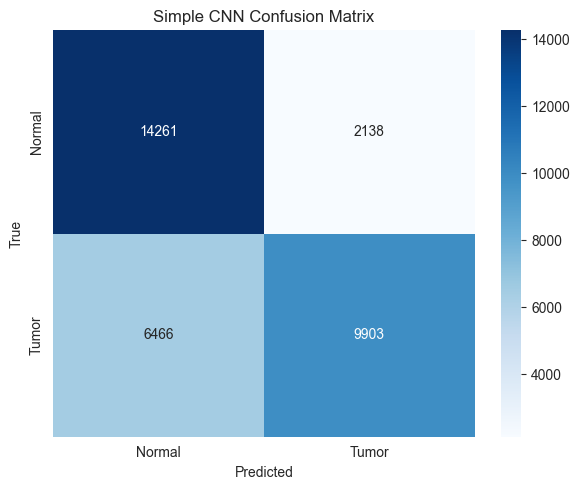


EfficientNet:
  AUC: 0.9355
  Accuracy: 0.7991
              precision    recall  f1-score   support

      Normal     0.7223    0.9724    0.8289     16399
       Tumor     0.9576    0.6255    0.7567     16369

    accuracy                         0.7991     32768
   macro avg     0.8400    0.7989    0.7928     32768
weighted avg     0.8399    0.7991    0.7929     32768



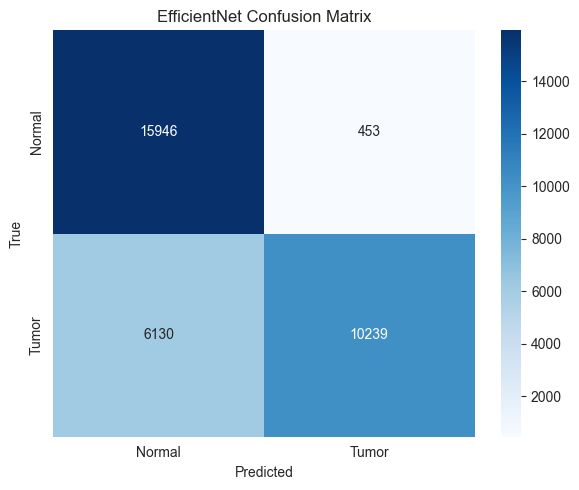

In [12]:
def evaluate_model(model, model_name):
    valid_x_norm = normalize_01(valid_x)
    y_pred_proba = model.predict(valid_x_norm, batch_size=64, verbose=0).flatten()
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    auc = roc_auc_score(valid_y, y_pred_proba)
    acc = accuracy_score(valid_y, y_pred)
    
    print(f'\n{model_name}:')
    print(f'  AUC: {auc:.4f}')
    print(f'  Accuracy: {acc:.4f}')
    print(classification_report(valid_y, y_pred, target_names=['Normal', 'Tumor'], digits=4))
    
    cm = confusion_matrix(valid_y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Tumor'],
                yticklabels=['Normal', 'Tumor'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    
    return y_pred_proba

cnn_probs = evaluate_model(cnn_model, 'Simple CNN')
eff_probs = evaluate_model(efficientnet_model, 'EfficientNet')

## 9. Threshold Optimization

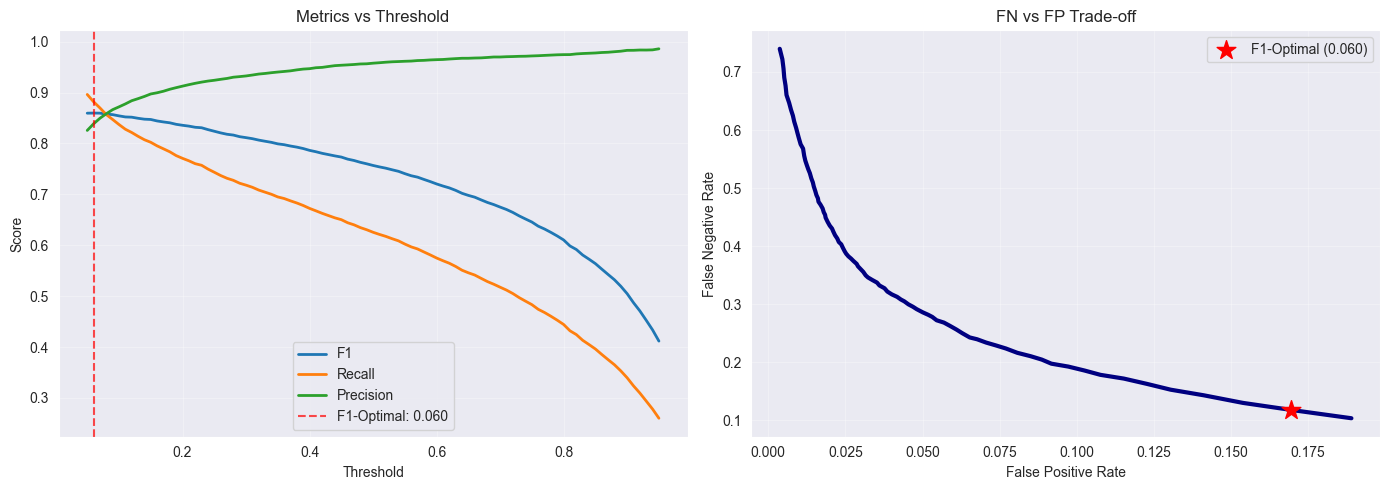


F1-Optimal Threshold: 0.060
  F1: 0.8597
  FN: 1,934 (11.8%)
  FP: 2,779 (16.9%)


In [13]:
def find_optimal_threshold(y_true, y_pred_proba, plot=True):
    thresholds = np.linspace(0.05, 0.95, 91)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'f1': f1,
            'recall': recall,
            'precision': precision,
            'fn': fn,
            'fp': fp,
            'fn_rate': fn / (tp + fn),
            'fp_rate': fp / (fp + tn)
        })
    
    df = pd.DataFrame(results)
    f1_optimal = df.loc[df['f1'].idxmax()]
    recall_90 = df.loc[(df['recall'] - 0.90).abs().idxmin()]
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        ax = axes[0]
        ax.plot(df['threshold'], df['f1'], label='F1', linewidth=2)
        ax.plot(df['threshold'], df['recall'], label='Recall', linewidth=2)
        ax.plot(df['threshold'], df['precision'], label='Precision', linewidth=2)
        ax.axvline(f1_optimal['threshold'], color='red', linestyle='--', alpha=0.7,
                   label=f'F1-Optimal: {f1_optimal["threshold"]:.3f}')
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Score')
        ax.set_title('Metrics vs Threshold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        ax = axes[1]
        ax.plot(df['fp_rate'], df['fn_rate'], linewidth=3, color='navy')
        ax.scatter(f1_optimal['fp_rate'], f1_optimal['fn_rate'],
                   color='red', s=200, marker='*', zorder=5,
                   label=f'F1-Optimal ({f1_optimal["threshold"]:.3f})')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('False Negative Rate')
        ax.set_title('FN vs FP Trade-off')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    print(f'\nF1-Optimal Threshold: {f1_optimal["threshold"]:.3f}')
    print(f'  F1: {f1_optimal["f1"]:.4f}')
    print(f'  FN: {int(f1_optimal["fn"]):,} ({f1_optimal["fn_rate"]:.1%})')
    print(f'  FP: {int(f1_optimal["fp"]):,} ({f1_optimal["fp_rate"]:.1%})')
    
    return {
        'f1_optimal': f1_optimal.to_dict(),
        'recall_90': recall_90.to_dict(),
        'all_results': df
    }

threshold_results = find_optimal_threshold(valid_y, eff_probs, plot=True)
OPTIMAL_THRESHOLD = threshold_results['f1_optimal']['threshold']

### 9.1 Apply Optimal Threshold

EfficientNet with Optimal Threshold (0.060):
  AUC: 0.9355
  Accuracy: 0.8562

              precision    recall  f1-score   support

      Normal     0.8757    0.8305    0.8525     16399
       Tumor     0.8386    0.8818    0.8597     16369

    accuracy                         0.8562     32768
   macro avg     0.8571    0.8562    0.8561     32768
weighted avg     0.8571    0.8562    0.8561     32768



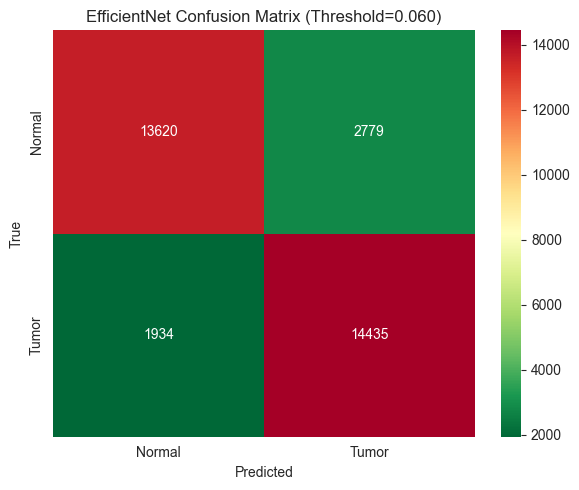

In [14]:
y_pred_optimal = (eff_probs >= OPTIMAL_THRESHOLD).astype(int)

auc = roc_auc_score(valid_y, eff_probs)
acc = accuracy_score(valid_y, y_pred_optimal)

print(f'EfficientNet with Optimal Threshold ({OPTIMAL_THRESHOLD:.3f}):')
print(f'  AUC: {auc:.4f}')
print(f'  Accuracy: {acc:.4f}\n')
print(classification_report(valid_y, y_pred_optimal,
                            target_names=['Normal', 'Tumor'], digits=4))

cm = confusion_matrix(valid_y, y_pred_optimal)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r',
            xticklabels=['Normal', 'Tumor'],
            yticklabels=['Normal', 'Tumor'])
plt.title(f'EfficientNet Confusion Matrix (Threshold={OPTIMAL_THRESHOLD:.3f})')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

## 10. Hyperparameter Tuning

In [15]:
class ExperimentTracker:
    def __init__(self):
        self.experiments = []
        self.results_file = os.path.join(RESULTS_DIR, 'experiments.json')
        if os.path.exists(self.results_file):
            with open(self.results_file, 'r') as f:
                self.experiments = json.load(f)
    
    def log(self, exp_name, params, metrics):
        self.experiments.append({
            'name': exp_name,
            'timestamp': datetime.now().isoformat(),
            'params': params,
            'metrics': metrics
        })
        with open(self.results_file, 'w') as f:
            json.dump(self.experiments, f, indent=2)
        print(f'Logged: {exp_name}')
    
    def summary(self):
        if not self.experiments:
            print('No experiments logged')
            return None
        
        data = []
        for exp in self.experiments:
            row = {'name': exp['name']}
            row.update(exp['params'])
            row.update(exp['metrics'])
            data.append(row)
        
        df = pd.DataFrame(data)
        if 'val_auc' in df.columns:
            df = df.sort_values('val_auc', ascending=False)
            print(df.to_string(index=False))
            best = df.iloc[0]
            print(f'\nBest: {best["name"]} (AUC: {best["val_auc"]:.4f})')
        return df

tracker = ExperimentTracker()

### 10.1 Hyperparameter Grid

In [16]:
hyperparameter_grid = {
    'class_weight_mult': [1.0, 1.2],
    'learning_rate': [5e-4, 1e-3],
    'dropout_rate': [0.3]
}

total_experiments = (len(hyperparameter_grid['class_weight_mult']) * 
                    len(hyperparameter_grid['learning_rate']) * 
                    len(hyperparameter_grid['dropout_rate']))

print(f'Hyperparameter Search: {total_experiments} experiments')
print(f'Est. time: {total_experiments * 45} mins')

FORCE_RETRAIN = False

Hyperparameter Search: 4 experiments
Est. time: 180 mins


### 10.2 Run Grid Search

In [ ]:
experiment_num = 0

for class_weight_mult in hyperparameter_grid['class_weight_mult']:
    for learning_rate in hyperparameter_grid['learning_rate']:
        for dropout_rate in hyperparameter_grid['dropout_rate']:
            
            experiment_num += 1
            exp_name = f'exp_{experiment_num:02d}_cw{class_weight_mult:.1f}_lr{learning_rate:.0e}_dr{dropout_rate:.1f}'
            
            print(f'\n[{experiment_num}/{total_experiments}] {exp_name}')
            
            if model_exists(exp_name) and not FORCE_RETRAIN:
                print('  Skipping (already trained)')
                continue
            
            model = create_efficientnet(dropout_rate=dropout_rate)
            class_weights = compile_model(model, lr=learning_rate, class_weight_mult=class_weight_mult)
            
            history = model.fit(
                train_generator,
                epochs=20,
                validation_data=valid_generator,
                callbacks=[
                    callbacks.EarlyStopping(monitor='val_auc', patience=5,
                                           restore_best_weights=True, mode='max'),
                    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                               patience=3, min_lr=1e-7)
                ],
                class_weight=class_weights,
                verbose=2
            )
            
            valid_x_norm = normalize_01(valid_x)
            y_pred_proba = model.predict(valid_x_norm, batch_size=64, verbose=0).flatten()
            
            threshold_res = find_optimal_threshold(valid_y, y_pred_proba, plot=False)
            opt_threshold = threshold_res['f1_optimal']['threshold']
            y_pred = (y_pred_proba >= opt_threshold).astype(int)
            
            val_auc = roc_auc_score(valid_y, y_pred_proba)
            val_acc = accuracy_score(valid_y, y_pred)
            
            cm = confusion_matrix(valid_y, y_pred)
            tn, fp, fn, tp = cm.ravel()
            
            tracker.log(
                exp_name,
                {
                    'class_weight_mult': class_weight_mult,
                    'learning_rate': learning_rate,
                    'dropout_rate': dropout_rate,
                    'optimal_threshold': opt_threshold
                },
                {
                    'val_auc': val_auc,
                    'val_acc': val_acc,
                    'fn_rate': fn / (tp + fn),
                    'fp_rate': fp / (fp + tn),
                    'fn_count': int(fn),
                    'fp_count': int(fp)
                }
            )
            
            save_model_weights(model, exp_name)
            del model
            gc.collect()

print('\nGrid search complete!')
results_df = tracker.summary()


[1/4] exp_01_cw1.0_lr5e-04_dr0.3
Epoch 1/20
313/313 - 75s - 239ms/step - accuracy: 0.7757 - auc: 0.8498 - loss: 0.4951 - val_accuracy: 0.5513 - val_auc: 0.6532 - val_loss: 1.1047 - learning_rate: 5.0000e-04
Epoch 2/20
313/313 - 72s - 229ms/step - accuracy: 0.8066 - auc: 0.8848 - loss: 0.4294 - val_accuracy: 0.6736 - val_auc: 0.8782 - val_loss: 0.7753 - learning_rate: 5.0000e-04
Epoch 3/20
313/313 - 1444s - 5s/step - accuracy: 0.8224 - auc: 0.8984 - loss: 0.4044 - val_accuracy: 0.5871 - val_auc: 0.8651 - val_loss: 1.0365 - learning_rate: 5.0000e-04
Epoch 4/20
313/313 - 261s - 834ms/step - accuracy: 0.8281 - auc: 0.9066 - loss: 0.3883 - val_accuracy: 0.5858 - val_auc: 0.8731 - val_loss: 1.1849 - learning_rate: 5.0000e-04
Epoch 5/20
313/313 - 75s - 239ms/step - accuracy: 0.8331 - auc: 0.9129 - loss: 0.3755 - val_accuracy: 0.7166 - val_auc: 0.8803 - val_loss: 0.6955 - learning_rate: 5.0000e-04
Epoch 6/20
313/313 - 77s - 246ms/step - accuracy: 0.8381 - auc: 0.9153 - loss: 0.3703 - val_accu

## 11. Results Summary

In [ ]:
if results_df is not None and len(results_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax = axes[0]
    for lr in results_df['learning_rate'].unique():
        subset = results_df[results_df['learning_rate'] == lr]
        ax.plot(subset['class_weight_mult'], subset['val_auc'],
                marker='o', linewidth=2, markersize=8, label=f'LR={lr:.0e}')
    ax.set_xlabel('Class Weight Multiplier')
    ax.set_ylabel('Validation AUC')
    ax.set_title('AUC vs Class Weight')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[1]
    ax.scatter(results_df['fp_rate'], results_df['fn_rate'],
               c=results_df['val_auc'], cmap='RdYlGn',
               s=200, alpha=0.7, edgecolors='black')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('False Negative Rate')
    ax.set_title('FN vs FP Trade-off (colored by AUC)')
    plt.colorbar(ax.collections[0], ax=ax, label='Val AUC')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print('No experiments to visualize yet')